In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from colorama import Fore

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats
import math

from tqdm.notebook import tqdm
from copy import deepcopy

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

plt.rcParams['axes.facecolor'] = primary_bgcolor

colors = [primary_blue, primary_blue2, primary_blue3, primary_grey, primary_black, primary_bgcolor, primary_green]
sns.palplot(sns.color_palette(colors))

In [ ]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.family'] = 'serif'

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">Tabular Playground Series 📚 - April 2021 📈</p>

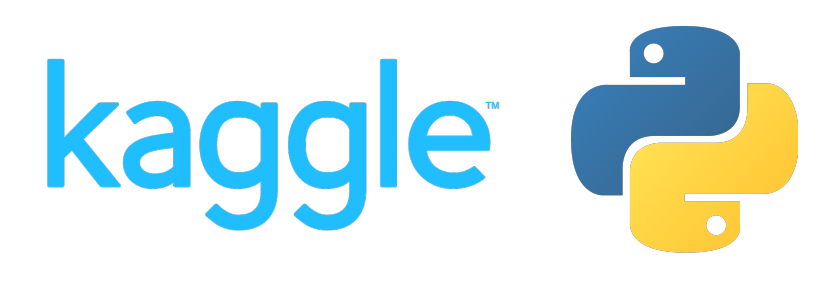

The main idea of this kernel is to compare the most popular AutoMl algorithems in terms of setup and competition performance (f1-score).

In all the cases I will just limit the time to 5 minutes (it could be better to use more time, but you can always fork and try yourselfs). The idea is to give a baseline so you can use the one is easier for you or the one the better performs.

As the data is synthetic, I will do just some simple feature engineering. With this method, we can also compare how all the libraries handle categorical data etc.

In recent years, the demand for machine learning experts has outpaced the supply, despite the surge of people entering the field. To address this gap, there have been big strides in the development of user-friendly machine learning software that can be used by non-experts. The first steps toward simplifying machine learning involved developing simple, unified interfaces to a variety of machine learning algorithms

<a id='table-of-contents'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">Table of Content</p>

* [1. Data visualization: Survival Analysis 📊](#1)
    * [1.1 Target](#1.1)
    * [1.2 Data missings](#1.2)
    * [1.3 Numerical Columns](#1.3)
    * [1.4 Categorical Columns](#1.4)
    * [1.5 Global correlation matrix](#1.5)
* [2 Feature Engineering](#2)
* [3. LightAutoML](#3)
* [4. H2O: AutoML](#4)
* [5. MLJAR AutoML](#5)
* [6. PyCaretL](#6)
* [7. EvalML alteryx](#7)

In [ ]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2021/train.csv')
train_df.columns = [column.lower() for column in train_df.columns]
# train_df = train_df.drop(columns=['passengerid'])

test_df = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2021/test.csv')
test_df.columns = [column.lower() for column in test_df.columns]

submission = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2021/sample_submission.csv')
submission.head()

train_df.head()

In [ ]:
feature_cols = train_df.drop(['survived', 'passengerid'], axis=1).columns
target_column = 'survived'

## Getting all the data that are not of "object" type. 
numerical_columns = ['age', 'fare']
categorical_columns = train_df[feature_cols].drop(columns=numerical_columns).columns

pure_num_cols = train_df[feature_cols].select_dtypes(include=['int64','float64']).columns
pure_cat_cols = train_df[feature_cols].select_dtypes(exclude=['int64','float64']).columns

print(len(numerical_columns), len(categorical_columns))

<a id='1'></a>
[back to top](#table-of-contents)
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Data visualization: EDA 📊</p>

The first thing that we can see is that we have some missing that we will have to handle later and that, as we knew, there are categorical and numerical features. 

Also, we know that the class is binary.

In [ ]:
train_df.info()

<a id='1.1'></a>
[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">1.1 Target Variable</p>

The first thing we are going to check is the distribution of the target feature. It's important to know if the class is balanced or not. If so, we would probably have to handle it.

In [ ]:
fig = px.histogram(
    train_df, 
    x=target_column, 
    color=target_column,
    color_discrete_sequence=[primary_blue, primary_grey],
)
fig.update_layout(
    title_text='Target distribution', # title of plot
    xaxis_title_text='Value', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    paper_bgcolor=primary_bgcolor,
    plot_bgcolor=primary_bgcolor,
)
fig.show()

<a id='1.2'></a>
[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">1.2 Data missings</p>

In this section we are going to take a fast look about the null values and their distribution.
We will handle those missing later,m but is important to have a first reference.

Ref: https://www.kaggle.com/subinium/tps-apr-highlighting-the-data

In [ ]:
nan_data = (train_df.isna().sum().sort_values(ascending=False) / len(train_df) * 100)[:6]
fig, ax = plt.subplots(1,1,figsize=(7, 5))

ax.bar(nan_data.index, 100, color=primary_grey, width=0.6)

bar = ax.bar(
    nan_data.index, 
    nan_data, 
    color=primary_blue, 
    width=0.6
)
ax.bar_label(bar, fmt='%.01f %%')
ax.spines.left.set_visible(False)
ax.set_yticks([])
ax.set_title('Null Data Ratio', fontweight='bold')

plt.show()

<a id='1.3'></a>
[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">1.3 Numerical features</p>

The first view over numerical variables is about show the diference distributions based on the class. As we can see, the `distplot` are very similar but there are some diferences:
- In `age` feature it seems that people between $18-42$ tends to die with higher probability than those between $40-70$ years
- In `fare` feature, those with lower values tend to die more than those with higher values

In [ ]:
num_rows, num_cols = 2,1
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 16), facecolor=primary_bgcolor)
f.suptitle('Distribution of Features', fontsize=20, fontweight='bold', fontfamily='serif', x=0.13)


for index, column in enumerate(train_df[numerical_columns].columns):
    i,j = (index // num_cols, index % num_cols)
    sns.kdeplot(train_df.loc[train_df[target_column] == 0, column], color=primary_grey, shade=True, ax=axes[i])
    sns.kdeplot(train_df.loc[train_df[target_column] == 1, column], color=primary_blue, shade=True, ax=axes[i])

# f.delaxes(axes[-1, -1])
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 8), facecolor=primary_bgcolor)
gs = fig.add_gridspec(1, 1)
ax0 = fig.add_subplot(gs[0, 0])

ax0.set_facecolor(primary_bgcolor)
ax0.text(-1.1, 0.26, 'Correlation of Continuous Features with Target', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-1.1, 0.24, 'There is no features that pass 0.3 correlation with target', fontsize=13, fontweight='light', fontfamily='serif')

chart_df = pd.DataFrame(train_df[pure_num_cols].corrwith(train_df[target_column]))
chart_df.columns = ['corr']
sns.barplot(x=chart_df.index, y=chart_df['corr'], ax=ax0, color=primary_blue, zorder=3, edgecolor='black', linewidth=1.5)
ax0.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
ax0.set_ylabel('')

for s in ["top","right", 'left']:
    ax0.spines[s].set_visible(False)

plt.show()

<a id='1.4'></a>
[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">1.4 Categorical features</p>

In this case we are going to check in general terms, the distribution of categories values based on survival chances:
- In the case of `name` and `cabin` there seems to be no possible information to stract, but will take a dive dive into those ones.
- In the case of `sex` and `embarked` we can see that `females` and those in the high class had more chance to survive

### Individual survival rate

* **Sex**
    * `Female` has higher chance to survived compared to `male`, this may also be the result of lifeboat priority for  `female` than `male`.
    
* **SibSp**
    * Most of the passengers in Synthanic are travel alone, this make the survival rate for passengers without `siblings / spouses` higher than passengers with siblings / spouses.
    
* **Parch**
    * As stated earlier, that most of the passengers in Synthanic are travel alone, this also make the survival rate for passenger that travel without `parents / children` are higher.
    * Survival rate for passengers that travel without `parents / children` is almost the same with the survival rate for passenger that travel without `siblings / spouses`.
    
* **Embarked**
    * Passengers that embarked from `Southampton` have the highest chance to survived.
    * The second highest survival rate are passengers that embarked from `Cherbourg`.

In [ ]:
train_0_df = train_df.loc[train_df[target_column] == 0]
train_1_df = train_df.loc[train_df[target_column] == 1]

num_rows, num_cols = 4,2
fig = make_subplots(rows=num_rows, cols=num_cols)

for index, column in enumerate(train_df[categorical_columns].columns):
    i,j = ((index // num_cols)+1, (index % num_cols)+1)
    data = train_0_df.groupby(column)[column].count().sort_values(ascending=False)
    data = data if len(data) < 10 else data[:10]
    fig.add_trace(go.Bar(
        x = data.index,
        y = data.values,
        name='Label: 0',
        marker_color=primary_grey,
        marker_line_color=primary_black,
        marker_line_width=1.5, 
        opacity=0.8,
    ), row=i, col=j)

    data = train_1_df.groupby(column)[column].count().sort_values(ascending=False)
    data = data if len(data) < 10 else data[:10]
    fig.add_trace(go.Bar(
        x = data.index,
        y = data.values,
        name='Label: 1',
        marker_color=primary_blue,
        marker_line_color=primary_black,
        marker_line_width=1.5, 
        opacity=0.8,
    ), row=i, col=j)
    
    fig.update_xaxes(
        title=column, 
        type='category', 
        row=i, 
        col=j
    )
    fig.update_layout(barmode='stack')
    
fig.update_layout(
    autosize=False,
    width=800,
    height=1300,
    showlegend=False,
    title='<span style="font-size:32px; font-family:Times New Roman">Categorical features</span>',
    paper_bgcolor=primary_bgcolor,
    plot_bgcolor=primary_bgcolor,
)
fig.show()

<a id='1.5'></a>
[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">1.5 Global correlation matrix</p>

We can see that name and ticket have very low correlation to survival. We can easily drop them or leave them and engineer some features from them later. Sex, Embarked and Pclass have the highest correlation with survival. The highest feature-to-feature correlation is Cabin-Pclass at 0.625.

In [ ]:
# label encoding
le = LabelEncoder()
le_data = train_df.copy().drop(columns=['passengerid'])

for col in pure_cat_cols:
    le_data[col] = le.fit_transform(le_data[col])  

corrdata = le_data

## correlation 
corr = corrdata.corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr1 = corr.mask(mask)

fig = ff.create_annotated_heatmap(
    z=corr1.to_numpy().round(2),
    x=list(corr1.index.values),
    y=list(corr1.columns.values),       
    xgap=3, ygap=3,
    zmin=0, zmax=1,
    colorscale='blugrn',
    colorbar_thickness=30,
    colorbar_ticklen=3,
)

fig.update_layout(
    title_text='<span style="font-size:32px; font-family:Times New Roman">Features Correlation Matrix</span>', 
    font_family="Serif",
    titlefont={'size': 24},
    width=800, height=700,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange='reversed', 
    paper_bgcolor=primary_bgcolor,
    plot_bgcolor=primary_bgcolor,
    margin=dict(l=70, r=70, t=70, b=70, pad=1),
)

fig.show()

<a id='2'></a>
[back to top](#table-of-contents)
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. Feature Engineering</p>

In [ ]:
def fix_features(all_df):
    # Fillna on cabin feature
    all_df["cabin"] = all_df["cabin"].fillna("Nan")
    all_df["cabin"] = all_df["cabin"].str[0]

    # Fillna Age based on pclass
    map_age_pclass = all_df[['age', 'pclass']].dropna().groupby('pclass').mean().to_dict()
    all_df['age'] = all_df['age'].mask(all_df['age'].isna(), all_df['pclass'].map(map_age_pclass['age']))

    print(all_df['age'].isna().sum())

    # Fillna Age based on pclass
    map_age_pclass = train_df[['fare', 'pclass']].dropna().groupby('pclass').mean().to_dict()
    all_df['fare'] = all_df['fare'].mask(all_df['fare'].isna(), all_df['pclass'].map(map_age_pclass['fare']))

    print(all_df['fare'].isna().sum())

    # Ticket, fillna with 'X', split string and take first split 
    all_df['ticket'] = all_df['ticket'].map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')
    
    # Name, take only surnames
    all_df['name'] = all_df['name'].apply(lambda x: str(x).split(',')[0])
    
    # Embarked
    all_df['embarked'] = all_df['embarked'].fillna('X')
    
    return all_df

In [ ]:
all_df = pd.concat([train_df, test_df]).reset_index(drop = True)

all_df = fix_features(all_df)

train_df, test_df = all_df[:len(train_df)], all_df[len(train_df):]
print(train_df.shape, test_df.shape)

In [ ]:
train_df.head()

<a id='3'></a>
[back to top](#table-of-contents)
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. LightAutoML</p>

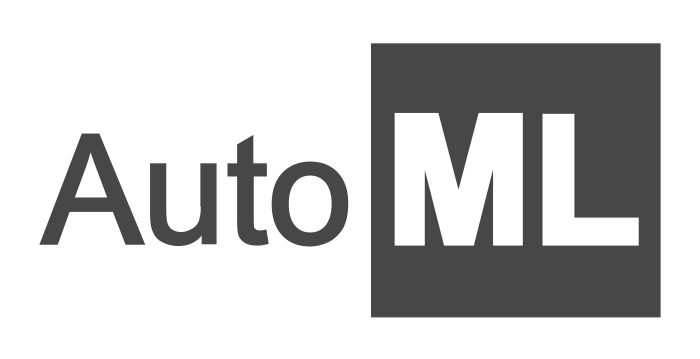

LightAutoML is open-source Python library aimed at automated machine learning. It is designed to be lightweight and efficient for various tasks with tabular, text data. LightAutoML provides easy-to-use pipeline creation, that enables:

* Automatic hyperparameter tuning, data processing.
* Automatic typing, feature selection.
* Automatic time utilization.
* Automatic report creation.
* Graphical profiling system.
* Easy-to-use modular scheme to create your own pipelines.

Ref: https://github.com/sberbank-ai-lab/LightAutoML

In [ ]:
!pip install -U lightautoml

In [ ]:
# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

import torch

In [ ]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 300 # Time in seconds for automl run

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [ ]:
def acc_score(y_true, y_pred, **kwargs):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

def f1_metric(y_true, y_pred, **kwargs):
    return f1_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

task = Task('binary', metric = f1_metric)

roles = {
    'target': 'survived',
    'drop': ['passengerid', 'name','ticket'],
}

In [ ]:
%%time 
automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
                       reader_params = {'n_jobs': N_THREADS})
oof_pred = automl.fit_predict(train_df, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

In [ ]:
%%time
test_pred = automl.predict(test_df)
print('Prediction for test data:\n{}\nShape = {}'.format(test_pred[:10], test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(acc_score(train_df['survived'].values, oof_pred.data[:, 0])))

In [ ]:
submission['Survived'] = (test_pred.data[:, 0] > 0.5).astype(int)
submission.to_csv('lightautoml_utilized_300s_f1_metric.csv', index = False)
submission.head()

<a id='4'></a>
[back to top](#table-of-contents)
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. H2O AutoML</p>

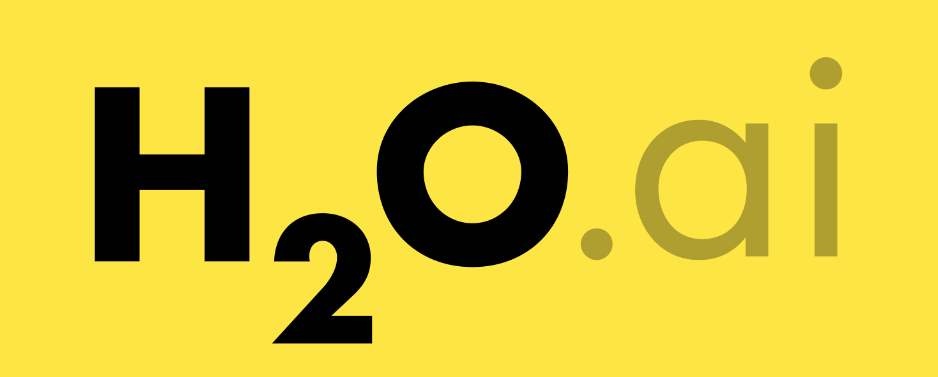

The H2O AutoML interface is designed to have as few parameters as possible so that all the user needs to do is point to their dataset, identify the response column and optionally specify a time constraint or limit on the number of total models trained.

In both the R and Python API, AutoML uses the same data-related arguments, x, y, training_frame, validation_frame, as the other H2O algorithms. Most of the time, all you’ll need to do is specify the data arguments. You can then configure values for max_runtime_secs and/or max_models to set explicit time or number-of-model limits on your run.

Ref: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

In [ ]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.init()

In [ ]:
train_hf = h2o.H2OFrame(train_df.copy())
test_hf = h2o.H2OFrame(test_df.copy())

In [ ]:
train_hf['survived'] = train_hf['survived'].asfactor()

In [ ]:
%%time
aml = H2OAutoML(
    seed=2021, 
    max_runtime_secs=300,
    nfolds = 3,
    exclude_algos = ["DeepLearning"]
)

aml.train(
    x=feature_cols.to_list(), 
    y=target_column, 
    training_frame=train_hf
)

In [ ]:
lb = aml.leaderboard 
lb.head(rows = lb.nrows)

In [ ]:
%%time
preds = aml.predict(h2o.H2OFrame(test_df.drop(columns=[target_column]).copy()))
preds_df = h2o.as_list(preds)

submission['Survived'] = preds_df['predict']
submission.to_csv('h2o_automl_300s_f1_metric.csv', index=False)
submission.head()

<a id='5'></a>
[back to top](#table-of-contents)
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5. MLJAR AutoML</p>

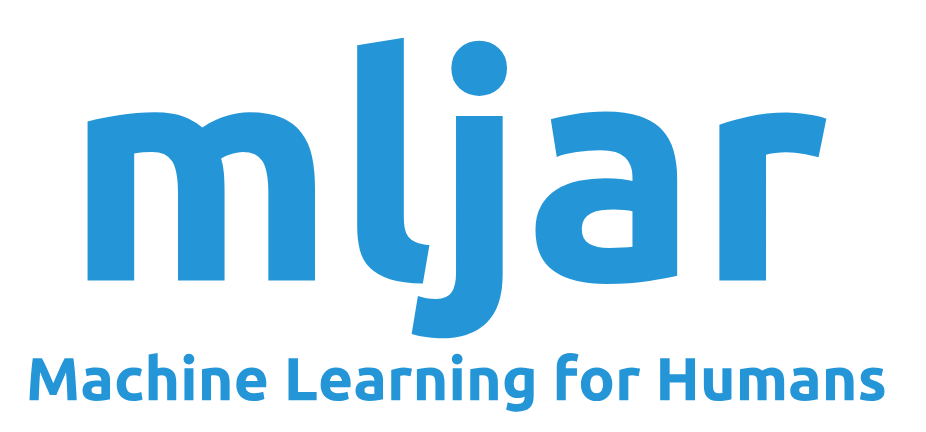

MLJAR is an Automated Machine Learning framework. It is available as Python package with code at GitHub: https://github.com/mljar/mljar-supervised

The MLJAR AutoML can work in several modes:

* **Explain** - ideal for initial data exploration
* **Perform** - perfect for production-level ML systems
* **Compete** - mode for ML competitions under restricted time budget. By the default, it performs advanced feature engineering like golden features search, kmeans features, feature selection. It does model stacking.
* **Optuna** - uses Optuna to highly tune algorithms: `Random Forest`, `Extra Trees`, `Xgboost`, `LightGBM`, `CatBoost`, `Neural Network`. Each algorithm is tuned with Optuna hperparameters framework with selected time budget (controlled with optuna_time_budget). By the default feature engineering is not enabled (you need to manually swtich it on, in AutoML() parameter).

Ref: https://www.kaggle.com/mt77pp/mljar-automl-tps-apr-21

*These execution cells are not going to be executed as MLJAR is getting troubles to be installed in Kaggle kernels environment*

In [ ]:
%%script false --no-raise-error
!apt-get install -y build-essential python3-dev

In [ ]:
%%script false --no-raise-error
!pip -q install pip --upgrade
!pip install graphviz --upgrade
!pip install dtreeviz
!pip install mljar-supervised

In [ ]:
%%script false --no-raise-error
from supervised.automl import AutoML # mljar-supervised

In [ ]:
%%script false --no-raise-error
%%time
automl = AutoML(
    mode="Compete", 
    eval_metric="f1",
    total_time_limit=300,
    features_selection=False # switch off feature selection
)
automl.fit(
    train[feature_cols], 
    train[target_column]
)

In [ ]:
%%script false --no-raise-error
%%time
preds = automl.predict(test[feature_cols])

submission['Survived'] = preds
submission.to_csv('mljar_automl_300s_f1_metric.csv', index=False)
submission.head()

<a id='6'></a>
[back to top](#table-of-contents)
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">6. PyCaret</p>

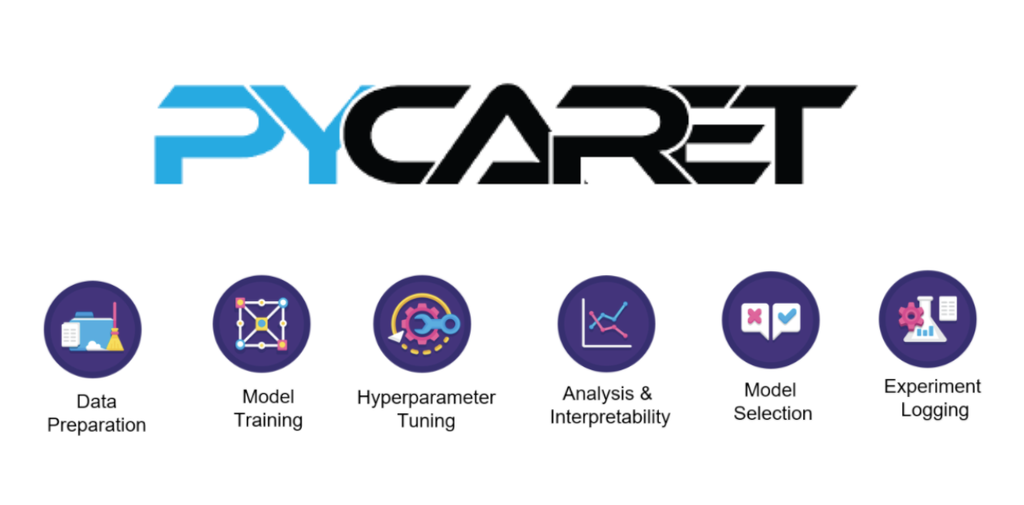

*These execution cells are not going to be executed as Pycaret spent so much resources and time and cant be executed in Kaggle kernels environment. You can always fork/clone and execute locally*

In [ ]:
%%script false --no-raise-error
!pip install pycaret

In [ ]:
%%script false --no-raise-error
from pycaret.classification import *

In [ ]:
%%script false --no-raise-error
from category_encoders.cat_boost import CatBoostEncoder

cat_train_df = train_df.copy()
cat_test_df = test_df.copy()

ce = CatBoostEncoder()

cols_to_encode = ['name', 'sex', 'ticket', 'cabin', 'embarked']
cat_train_df[pure_cat_cols] = ce.fit_transform(cat_train_df[pure_cat_cols], cat_train_df[target_column])
cat_test_df[pure_cat_cols] = ce.transform(cat_test_df[pure_cat_cols])

In [ ]:
train_df.head()

In [ ]:
%%script false --no-raise-error
setup(
    data = cat_train_df[feature_cols.to_list() + [target_column]], 
    target = target_column,
    silent = True,
)

In [ ]:
%%script false --no-raise-error
%%time
best_models = compare_models(
    sort='F1', 
    n_select=5, 
    budget_time=300,
) # we will use it later

In [ ]:
%%script false --no-raise-error
# select best model 
best = automl(optimize = 'F1')

In [ ]:
%%script false --no-raise-error
plot_model(best, plot = 'confusion_matrix')

plot_model(best, plot = 'feature_all')

<a id='7'></a>
[back to top](#table-of-contents)
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">7. EvalML: AutoML</p>

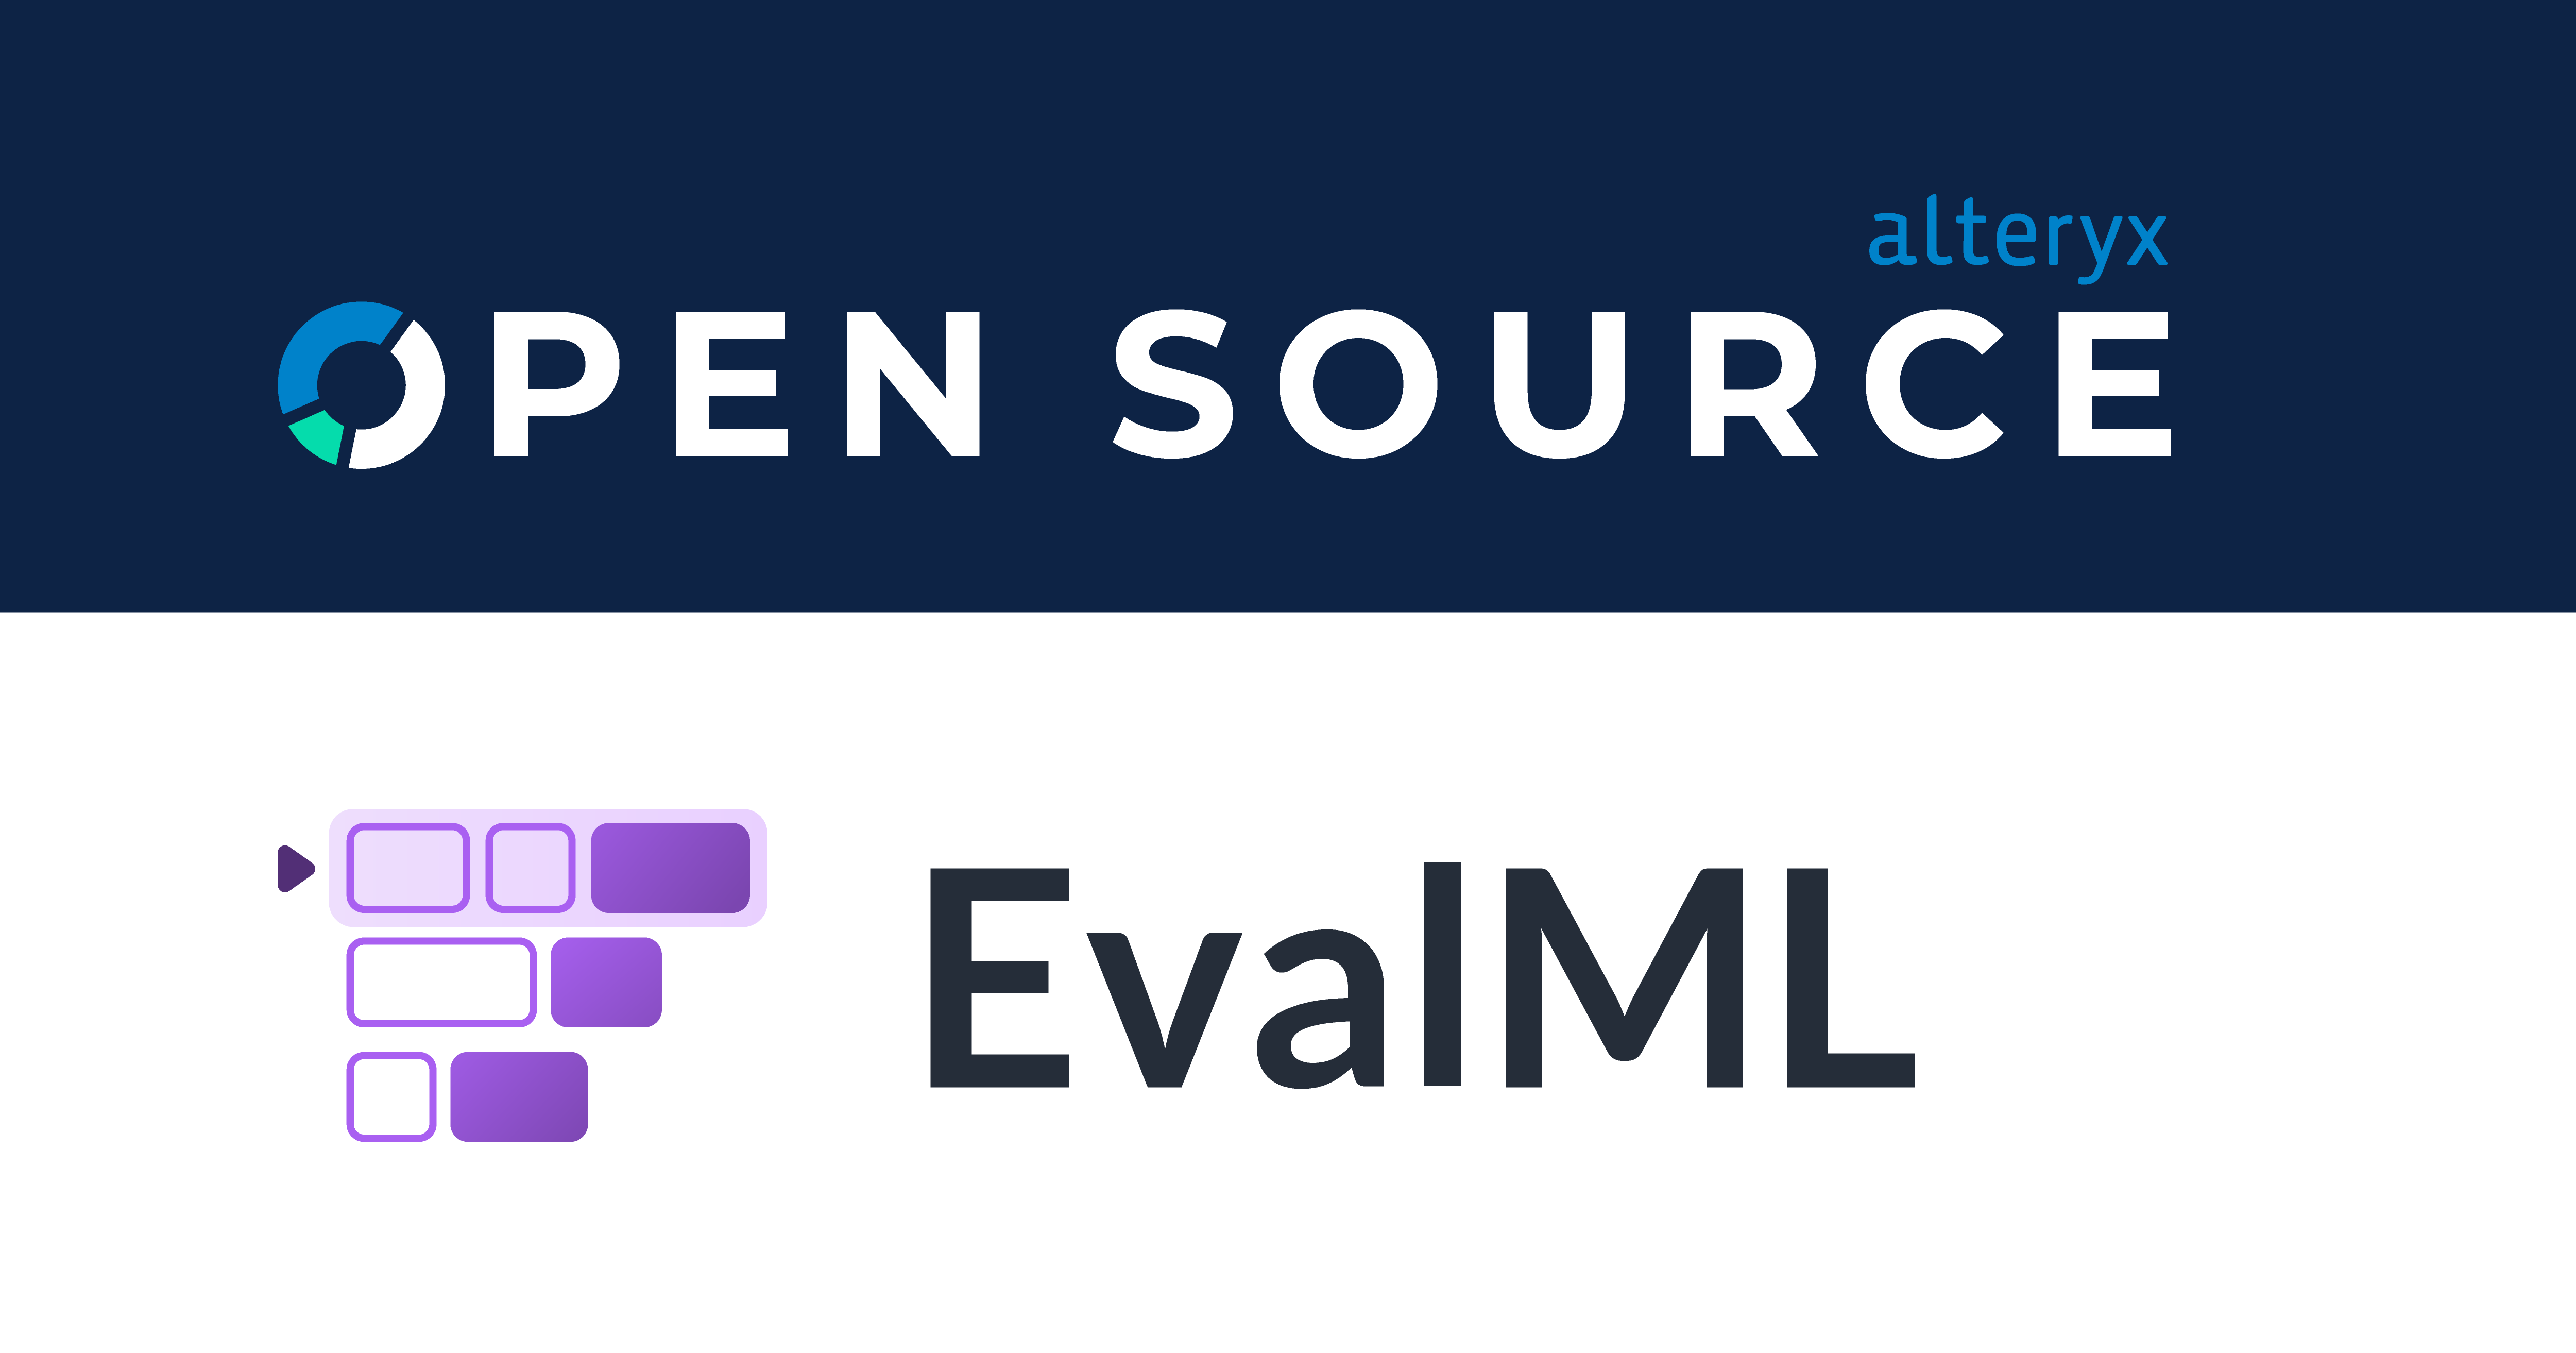

EvalML is an AutoML library which builds, optimizes, and evaluates machine learning pipelines using domain-specific objective functions.

**Key Functionality**
* **Automation** - Makes machine learning easier. Avoid training and tuning models by hand. Includes data quality checks, cross-validation and more.
* **Data Checks** - Catches and warns of problems with your data and problem setup before modeling.
* **End-to-end** - Constructs and optimizes pipelines that include state-of-the-art preprocessing, feature engineering, feature selection, and a variety of modeling techniques.
* **Model Understanding** - Provides tools to understand and introspect on models, to learn how they'll behave in your problem domain.
* **Domain-specific** - Includes repository of domain-specific objective functions and an interface to define your own.

Ref: https://evalml.alteryx.com/en/latest/_modules/evalml/automl/automl_search.html

In [ ]:
!pip install evalml

In [ ]:
from evalml.automl import AutoMLSearch

In [ ]:
X = train_df.drop(columns=[target_column, 'passengerid'])
y = train_df[target_column]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
%%time
automl = AutoMLSearch(
    X_train=X_train, 
    y_train=y_train, 
    problem_type='binary',
    random_seed=2021,
    max_time=300,
)

In [ ]:
automl.search()

In [ ]:
automl.rankings

In [ ]:
%%time
pipeline = automl.best_pipeline
pipeline.fit(X, y)

In [ ]:
preds = pipeline.predict(test_df.drop([target_column, 'passengerid'], axis=1))

submission['Survived'] = preds.to_series().astype(int)
submission.to_csv('evalml_automl_300s_f1_metric.csv', index=False)
submission.head()